**_Autor_**: Rubén del Mazo Rodríguez

# Regresión logística con una mentalidad de red neuronal

En este archivo se construye un clasificador binario utilizando la regresión logística. Se usa en la implementación una mentalidad de red neuronal, la más sencilla posible, es decir, monocapa y mononeuronal.

**Puntos principales:**
- Construir la arquitectura general de un algoritmo de aprendizaje:
    - Inicialización de parámetros.
    - Cálculo de la función de coste y su gradiente.
    - Uso de algoritmo de optimización (descenso del gradiente).
- Agrupar las tres funciones anteriores en una función principal para crear el modelo y aplicarlas en el orden correcto.

Este modelo se podrá aplicar a cualquier problema de clasificación binaria. Se hará uso de un conjunto de datos disponible públicamente en la web, puesto que es inviable recabar por cuenta propia miles de imágenes necesarias para aproximarnos a un conjunto de datos para aprendizaje profundo.

El objetivo de este trabajo no es entrenar un modelo de regresión logística o red neuronal perfectamente ajustado al conjunto de datos, sino explicar el proceso de creación y cómo funcionan.

## Contenidos
- [1 - Librerías](#1)
- [2 - Descripción y procesamiento de los datos](#2)
- [3 - Arquitectura general del algoritmo de aprendizaje](#3)
- [4 - Construir las partes de nuestro algoritmo](#4)
    - [4.1 - Función de activación - Sigmoide](#4-1)
    - [4.2 - Inicialización de parámetros](#4-2)
    - [4.3 - Propagación hacia delante y retropropagación (_forward y backward propagation_)](#4-3)
    - [4.4 - Optimización](#4-4)
    - [4.5 - Predicción](#4-5)
- [5 - Creación del modelo de aprendizaje](#5)
- [6 - Análisis](#6)

<a name='1'></a>
## 1 - Librerías ##

En primer lugar, importamos y ejecutamos las librerías necesarias:

- [numpy](https://numpy.org/doc/1.24/) es el paquete fundamental para la computación científica con Python.
- [h5py](http://www.h5py.org) es un paquete comúnmente utilziado para interactuar con datos almacenados en archivos H5.
- [matplotlib](http://matplotlib.org) es la librería más famosa para dibujar gráficos en python.
- [sklearn](https://scikit-learn.org/stable/) es una biblioteca para aprendizaje automático de software libre.

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<a name='2'></a>
## 2 - Descripción y procesamiento de los datos

El conjunto de datos que se va a utilizar contiene imágenes variadas, dividiéndose en un conjunto de datos de entrenamiento y otro de prueba. En este conjunto de datos, las imágenes correspondientes a gatos están etiquetadas como `y = 1` y el resto como `y = 0`. Cada imagen tiene dimensiones `(num_px, num_px, 3)`, donde el 3, como ya hemos visto en el trabajo, corresponde a los canales RGB. Al ser el alto y el ancho iguales a `num_px`, las imágenes son cuadradas. En resumen, con estos datos se construirá un algoritmo de reconocimiento de imágenes que pueda clasificar correctamente si en las imágenes hay, o no, gatos.

Carguemos los datos y familiarizémonos con ellos:

In [2]:
def cargar_dataset():
    train_dataset = h5py.File('datos/train_gato_vs_otros.h5', "r")
    # características del conjunto de entrenamiento
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    # etiquetas del conjunto de entrenamiento
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('datos/test_gato_vs_otros.h5', "r")
    # características del conjunto de prueba
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    # etiquetas del conjunto de pruebas
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])
    
    # listado de las clases
    clases = np.array(test_dataset["list_classes"][:]) 
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, clases

En muchos casos se utilizarán palabras **anglosajonas** de uso habitual en el aprendizaje automático, tales como _train, test, dataset, index_, etc.

In [3]:
# Cargamos los datos
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, clases = cargar_dataset()

In [4]:
# Clases
print(clases)

[b'non-cat' b'cat']


Se ha añadido "\_orig" a los nombres de los conjuntos de datos que a continuación se preprocesarán. Tras el preprocesamiento, obtendremos train_set_x y test_set_x (las etiquetas train_set_y y test_set_y no necesitan ningún preprocesamiento).

Cada línea de train_set_x_orig y test_set_x_orig es una matriz que representa una imagen. Podemos visualizar ejemplos ejecutando el siguiente código.

y = [0], no es la imagen de una gato


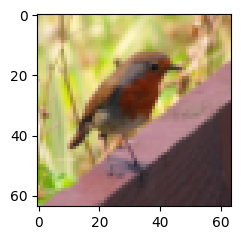

In [5]:
# Ejemplo de dos imágenes
index = 10
fig = plt.figure(figsize=(2.5,2.5))
ax = fig.add_subplot(111)
ax.imshow(train_set_x_orig[index], interpolation='nearest', aspect='auto')
print(f'y = {str(train_set_y[:, index])}{", no" if train_set_y[:, index] == 0 else ","} es la imagen de una gato')

y = [1], es la imagen de una gato


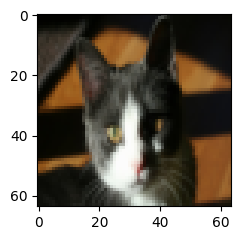

In [6]:
index = 19
fig = plt.figure(figsize=(2.5,2.5))
ax = fig.add_subplot(111)
ax.imshow(train_set_x_orig[index], interpolation='nearest', aspect='auto')
print (f'y = {str(train_set_y[:, index])}{", no" if train_set_y[:, index] == 0 else ","} es la imagen de una gato')

> **Nota**: Muchos de los errores de software en el aprendizaje profundo se deben a dimensiones de vectores y matrices que no concuerdan. Es un aspecto al que se debe prestar mucha atención.

Veamos a continuación el número de ejemplos de entrenamiento, `m_train` y `m_text`, el número de píxeles por imagen `num_px` y las dimensiones de cada conjunto de datos:

In [7]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print("Número de ejemplos de entrenamiento: m_train = " + str(m_train))
print("Número de ejemplos de prueba: m_test = " + str(m_test))
print("Altura/Anchura de cada imagen: num_px = " + str(num_px))
print("Dimensiones de cada imagen: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("Dimensiones de train_set_x_orig: " + str(train_set_x_orig.shape))
print("Dimensiones de train_set_y: " + str(train_set_y.shape))
print("Dimensiones de test_set_x_orig: " + str(test_set_x_orig.shape))
print("Dimensiones de test_set_y: " + str(test_set_y.shape))

Número de ejemplos de entrenamiento: m_train = 209
Número de ejemplos de prueba: m_test = 50
Altura/Anchura de cada imagen: num_px = 64
Dimensiones de cada imagen: (64, 64, 3)
Dimensiones de train_set_x_orig: (209, 64, 64, 3)
Dimensiones de train_set_y: (1, 209)
Dimensiones de test_set_x_orig: (50, 64, 64, 3)
Dimensiones de test_set_y: (1, 50)


**Número de imágenes en `m_train` y `m_test` y `num_px`**: 
<table style="width:15%">
  <tr>
    <td> m_train </td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>m_test</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>num_px</td>
    <td> 64 </td> 
  </tr>
</table>

Como se ha hablado en el apartado teórico y en los anexos, es conveniente para el análisis de imágenes reorganizar las matrices (num_px, num_px, 3) en matrices NumPy de dimensiones (num_px $*$ num_px $*$ 3, 1). Por lo tanto, vamos a reorganizar las imágenes de entrenamiento y prueba, de dimensiones (num_px, num_px, 3) en vectores de dimensiones (num\_px $*$ num\_px $*$ 3, 1). Tras esto, nuestro conjunto de datos de entrenamiento (y prueba) es una matriz NumPy donde cada columna representa una imagen aplanada. Debe haber m_train (respectivamente, m_test) columnas. 

Recordemos que nuestro objetivo es que los datos estén organizados en las siguiente dimensiones: $X \in \mathbb{R}^{n_{x}\times m}$. `train_set_x_orig` tiene dimensiones (m\_train, num\_px, num\_px, 3) y `test_set_x_orig` (m_test, num_px, num_px, 3). Lo que queremos es que las dimensiones sean: `train_set_x_orig` (num\_px\*num\_px\*3, m_train) y `test_set_x_orig` (num\_px\*num\_px\*3, m_test). Una forma de convertir una matriz X de dimensiones (a,b,c,d) en otra de dimensiones (b\*c\*d, a) es usando:
 
```python
X_re = X.reshape(X.shape[0], -1).T      # X.T es la traspuesta de X
```

In [8]:
train_set_x_re = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_re = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print("Dimensiones de train_set_x redimensionado: " + str(train_set_x_re.shape))
print("Dimensiones de train_set_y: " + str(train_set_y.shape))
print("Dimensiones de test_set_x redimensionado: " + str(test_set_x_re.shape))
print("Dimensiones de test_set_y: " + str(test_set_y.shape))

Dimensiones de train_set_x redimensionado: (12288, 209)
Dimensiones de train_set_y: (1, 209)
Dimensiones de test_set_x redimensionado: (12288, 50)
Dimensiones de test_set_y: (1, 50)


Para representar imágenes en color, hay que especificar los canales rojo, verde y azul (RGB) para cada píxel, por lo que el valor del píxel es en realidad un vector de tres números que van de 0 a 255.

Un paso común de preprocesamiento en el aprendizaje automático es centrar y estandarizar el conjunto de datos. Por ejemplo, restando la media de toda la matriz NumPy para cada ejemplo, y luego dividiendo cada ejemplo por la desviación estándar de la matriz. Pero para los conjuntos de datos de imágenes, es más simple y conveniente simplemente dividir cada fila del conjunto de datos por 255 (el valor máximo de un canal de píxeles).

Normalicemos el conjunto de datos.

In [9]:
train_set_x = train_set_x_re / 255.
test_set_x = test_set_x_re / 255.

>Pasos habituales para preprocesar un conjunto de imágenes:
>- Determinar las dimensiones y tamaños de los datos (m_entrenamiento, m_prueba, num_px, ...).
>- Redimensionar los conjuntos de datos de modo que cada ejemplo sea un vector de tamaño (num_px \* num_px \* 3, 1).
>- Normalizar los datos.

<a name='3'></a>
## 3 - Arquitectura general del algoritmo de aprendizaje ##

Comencemos con la creación del clasificador de imágenes utilizando la regresión logística. La siguiente imagen explica por qué la regresión logística es una red mononeuronal y monocapa, es decir, el tipo más sencillo posible:

<img src="imagenes/arquitectura_general.png" style="width:600px;height:400px;">

Podemos observar que la imagen ha sido particularizada para este set de datos, donde el producto de sus tres dimensiones es 12288. Es decir, cada ejemplo de entrenamiento $x^{(i)}$ tendrá dimensiones $\mathbb{R}^{12288}$ y, por tanto, el vector de pesos tendrá las mismas dimensiones, $w \in \mathbb{R}^{12288}$.

**Fórmulas del algoritmo:**:

Como se ha visto en la teoría, para cada ejemplo $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = \sigma(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

La función de coste se calcula sobre la suma de todos los ejemplos de entrenamiento, dividido entre el número de ejemplos de entrenamiento:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$$

**Pasos clave**:

- Inicializar los parámetros del modelo.
- Hallar los mejores parámetros _w_ y _b_ para el modelo minimizando la función de coste.
- Usar los parámetros hallados para hacer predicciones sobre el conjunto de datos de prueba.
- Analizar los resultados finales y sacar conclusiones.

<a name='4'></a>
## 4 - Construir las partes de nuestro algoritmo

Los pasos pirncipales para la construcción de una red neuronal son:
1. Definir la estructura del modelo (aspectos como el número de características de entrada).
2. Inicializar los parámetros del modelo.
3. Bucles:
    - Calcular la función de pérdida en cada paso (**propagación hacia delante o _forward propagation_**)
    - Calcular el gradiente en cada paso (**retropropagación o _backward propagation_**)
    - Actualización de los parámetros (aplicar el **descenso del gradiente**).

Todo esto se comenta en la teoría. Es habitual crear el código de los pasos por separado y luego integrar todos en una función que podemos llamar `modelo()`.

<a name='4-1'></a>
### 4.1 - Función de activación - Sigmoide

Usaremos el código ya implementado en "Implementación_de_funciones_con_NumPy.ipynb". Es necesario calcular $\sigma(z) = \frac{1}{1 + e^{-z}}$ for $z = w^T x + b$ para realizar predicciones.

In [10]:
def sigmoide(z):
    """
    Calcula el sigmoide de z.
    
    Argumentos:
    x -- Un escalar o matriz numpy

    Devuelve:
    s -- sigmoide(z)
    """
    
    s = 1/(1 + np.exp(-z))
    
    return s

<a name='4-2'></a>
### 4.2 - Inicialización de parámetros

En este caso inicializaremos los parámetros _w_ y _b_ a cero. Hay otras inicializaciones, esta es la más básica y cómoda para explicar los procesos en este archivo introductorio.

In [11]:
def inicializar_con_zeros(dim):
    """
    Esta función crea un vector de ceros de dimensiones (dim, 1) para w e inicializa b a 0.
    
    Argumentos:
    dim -- tamaño del vector w que queremos (o número de parámetros en este caso).
    
    Devuelve:
    w -- vector inicializado de forma (dim, 1)
    b -- escalar inicializado (corresponde al sesgo) de tipo float
    """
    
    # Por defecto el dtype es numpy.float64.            
    w = np.zeros((dim, 1))
    # Es importante especificar (dim, 1) y no poner solo (dim) para evitar problemas con las dimensiones de los arrays de NumPy.
    b = 0.

    return w, b

<a name='4-3'></a>
### 4.3 - Propagación hacia delante y retropropagación (_forward y backward propagation_)

Una vez inicializados los parámetros, podemos realizar las propagaciones para hallar los parámetros _w_ y _b_. Para ello, se implementará la función `propagacion()` que calcula la función de coste y su gradiente. Se utilizán las técnicas de vectorización mencionadas en los anexos.

_Forward propagation_:
- Se recibe una matriz $X \in \mathbb{R}^{n_{x}\times m} = \mathbb{R}^{12288\times 209} $.
- Calculamos la predicción de la regresión logística: $\hat{y} = A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Calculamos la función de coste: $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

_Backward propagation_:

Según las derivadas que se calcularon en la teoría, la aplicación de forma matricial es:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{5}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{6}$$

In [12]:
def propagacion(w, b, X, Y):
    """
    Implementa la función de coste y su gradiente para la propagación explicada anteriormente

    Argumentos:
    w -- pesos, una matriz numpy de tamaño (num_px * num_px * 3, 1)
    b -- sesgo, un escalar
    X -- datos de tamaño (num_px * num_px * 3, número de ejemplos)
    Y -- vector de etiquetas (contiene 0 si no es gato, 1 si es gato) de tamaño (1, número de ejemplos)

    Devuelve:
    coste -- función de coste de probabilidad logarítmica negativa para regresión logística
    dw -- gradiente de la pérdida con respecto a w, por tanto la misma dimensión que w
    db -- gradiente de la pérdida con respecto a b, por lo tanto la misma dimensión que b
    """
    
    m = X.shape[1]
    # Forward propagation
    A = sigmoide(w.T @ X + b)
    coste = np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)) / -m

    # Backward propagation
    dw = X @ (A - Y).T / m
    db = np.sum(A - Y) / m
    
    coste = np.squeeze(np.array(coste))

    grads = {"dw": dw,
             "db": db}
    
    return grads, coste

<a name='4-4'></a>
### 4.4 - Optimización

Una vez inicializados los parámetros y pudiendo calcular la función de coste y su gradiente, procedemos al último paso del descenso del gradiente: actualizar los parámetros. Este ciclo se repite hasta alcanzar un mínimo en la función de coste o que se ponga limite al número de ciclos.

El objetivo es hallar $w$ y $b$ minimizando la función de coste $J$. Para un parámetro $\theta$, la fórmula para actualizarlo es $ \theta = \theta - \alpha \text{ } d\theta$, donde $\alpha$ es la tasa de aprendizaje.

In [13]:
def optimizar(w, b, X, Y, num_iteraciones=100, tasa_aprendizaje=0.009, dibujar_coste=False):
    """
    Esta función optimiza w y b ejecutando un algoritmo de descenso del gradiente.
    
    Argumentos:
    w -- pesos, un array numpy de tamaño (num_px * num_px * 3, 1)
    b -- sesgo, un escalar
    X -- datos de forma (num_px * num_px * 3, número de ejemplos)
    Y -- vector de etiquetas (contiene 0 si no es gato, 1 si es gato) de tamaño (1, número de ejemplos)
    num_iterations -- número de iteraciones del bucle de optimización
    tasa_aprendizaje -- tasa de aprendizaje de la regla de actualización de descenso de gradiente
    dibujar_coste -- True para imprimir la pérdida cada 100 pasos
    
    Devuelve:
    parametros -- diccionario que contiene los pesos w y el sesgo b
    grads -- diccionario que contiene los gradientes de las ponderaciones y el sesgo con respecto a la función de coste
    costes -- lista de todos los costes calculados durante la optimización, que se utilizarán para trazar la curva de aprendizaje.
    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costes = []
    
    for i in range(num_iteraciones):

        grads, coste = propagacion(w, b, X, Y)

        # Obtenemos las derivadas de los resultados de propagacion()
        dw = grads["dw"]
        db = grads["db"]
        
        # Actualizacion simultanea de los parametros
        w -= tasa_aprendizaje * dw
        b -= tasa_aprendizaje * db

        # Guardamos los costes
        if i % 100 == 0:
            costes.append(coste)
        
            # Mostrar el coste cada 100 iteraciones de entrenamiento
            if dibujar_coste:
                print("Coste tras cada iteración %i: %f" %(i, coste))
    
    parametros = {"w": w,
                  "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return parametros, grads, costes

<a name='4-5'></a>
### Predicción
La función anterior mostrará los valores aprendidos de w y b. Podemos utilizar w y b para predecir las etiquetas de un conjunto de datos X. Hay dos pasos para calcular las predicciones:

1. Calculamos $\hat{Y} = A = \sigma(w^T X + b)$ con los valores de _w_ y _b_ hallados.

2. Convertirmos cada uno de los valores de _A_ en 0 (si el valor de activación es <= 0.5) o 1 (si la activación es > 0.5) y lo almacenamos en un vector `Y_prediccion`. 

In [14]:
def predecir(w, b, X):
    '''
    Predecir si la etiqueta es 0 o 1 utilizando los parámetros de regresión logística aprendidos (w, b)
    
    Argumentos:
    w -- pesos, una matriz numpy de tamaño (num_px * num_px * 3, 1)
    b -- sesgo, un escalar
    X -- datos de tamaño (num_px * num_px * 3, número de ejemplos)
    
    Devuelve
    Y_prediccion -- una matriz numpy (vector) que contiene todas las predicciones (0/1) para los ejemplos en X.
    '''
    
    m = X.shape[1]
    Y_prediccion = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Calcular el vector de salida de la unica neurona, "A".
    A = sigmoide(w.T @ X + b)
    
    for i in range(A.shape[1]):
        if A[0, i] > 0.5:
            Y_prediccion[0, i] = 1
        else:
            Y_prediccion[0, i] = 0        
    
    return Y_prediccion

**Resumen:**

- Inicializar (w,b)
- Optimizar la pérdida iterativamente para hallar los parámetros optimizados (w,b):
    - Calcular el coste y su gradiente.
    - Actualizar los parámetros con el descenso del gradiente.
- Utilizar los parámetros optimizados (w,b) para predecir las etiquetas para un determinado conjunto de ejemplos.

<a name='5'></a>
## 5 - Creación del modelo de aprendizaje ##

Por último, estructuraremos el modelo general utilizando todas las funciones implementadas anteriormente, en el orden correcto.

In [15]:
def modelo(X_train, Y_train, X_test, Y_test, num_iteraciones=2000, tasa_aprendizaje=0.05, dibujar_coste=False):
    """
    Construye el modelo de regresión logística en forma de red neuronal.
    
    Argumentos:
    X_train -- conjunto de entrenamiento representado por una matriz numpy de forma (num_px * num_px * 3, m_train)
    Y_train -- etiquetas de entrenamiento representadas por una matriz numpy (vector) de dimensiones (1, m_train)
    X_test -- conjunto de pruebas representado por una matriz numpy de dimensiones (num_px * num_px * 3, m_test)
    Y_test -- etiquetas de prueba representadas por una matriz numpy (vector) de forma (1, m_test)
    num_iteraciones -- hiperparametro que representa el número de iteraciones para optimizar los parámetros
    tasa_aprendizaje -- hiperparametro que representa la tasa de aprendizaje utilizada en la regla de actualización de optimize()
    dibujar_coste -- Establecer a True para imprimir el coste cada 100 iteraciones
    
    Devuelve:
    d -- diccionario que contiene la información del modelo.
    """
    
    w, b = inicializar_con_zeros(dim=X_train.shape[0])
    
    # Descenso del gradiente
    parametros, grads, costes = optimizar(w, b, X_train, Y_train, num_iteraciones, tasa_aprendizaje, dibujar_coste)
    
    # Parametros w y b tras aplicar el descenso del gradiente
    w = parametros['w']
    b = parametros['b']
    
    # Prediccion en test y train
    Y_prediccion_test = predecir(w, b, X_test)
    Y_prediccion_train = predecir(w, b, X_train)
    
    # Mostrar la métrica de precisión en train y test
    print("\nPrecisión(accuracy) en train: {} %".format(100 - np.mean(np.abs(Y_prediccion_train - Y_train)) * 100))
    print("Precision(accuracy) en test: {} %".format(100 - np.mean(np.abs(Y_prediccion_test - Y_test)) * 100))
    
    d = {"costes": costes,
         "Y_prediccion_test": Y_prediccion_test, 
         "Y_prediccion_train" : Y_prediccion_train, 
         "w" : w, 
         "b" : b,
         "tasa_aprendizaje" : tasa_aprendizaje,
         "num_iteraciones": num_iteraciones}
    
    return d

Con la siguiente celda se ejecuta el modelo para nuestro conjunto de datos:

In [16]:
modelo_regresion_logistica = modelo(train_set_x, train_set_y, test_set_x, test_set_y, num_iteraciones=2100, tasa_aprendizaje=0.005, dibujar_coste=True)

Coste tras cada iteración 0: 0.693147
Coste tras cada iteración 100: 0.584508
Coste tras cada iteración 200: 0.466949
Coste tras cada iteración 300: 0.376007
Coste tras cada iteración 400: 0.331463
Coste tras cada iteración 500: 0.303273
Coste tras cada iteración 600: 0.279880
Coste tras cada iteración 700: 0.260042
Coste tras cada iteración 800: 0.242941
Coste tras cada iteración 900: 0.228004
Coste tras cada iteración 1000: 0.214820
Coste tras cada iteración 1100: 0.203078
Coste tras cada iteración 1200: 0.192544
Coste tras cada iteración 1300: 0.183033
Coste tras cada iteración 1400: 0.174399
Coste tras cada iteración 1500: 0.166521
Coste tras cada iteración 1600: 0.159305
Coste tras cada iteración 1700: 0.152667
Coste tras cada iteración 1800: 0.146542
Coste tras cada iteración 1900: 0.140872
Coste tras cada iteración 2000: 0.135608

Precisión(accuracy) en train: 99.04306220095694 %
Precision(accuracy) en test: 70.0 %


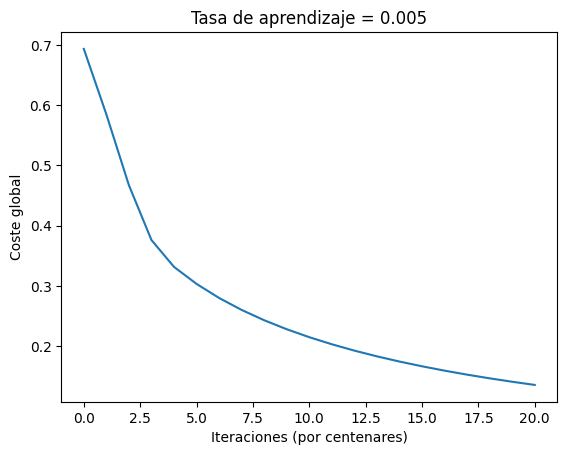

In [17]:
# Dibujemos la curva de aprendizaje del modelo, de acuerdo al coste global, J(w,b)
costes = np.squeeze(modelo_regresion_logistica['costes'])
plt.plot(costes)
plt.ylabel('Coste global')
plt.xlabel('Iteraciones (por centenares)')
plt.title("Tasa de aprendizaje = " + str(modelo_regresion_logistica["tasa_aprendizaje"]))
plt.show()

**Interpretación**:

La precisión del conjunto de entrenamiento es cercana al 100%, lo cual indica que el modelo funciona y tiene capacidad suficiente para ajustarse a los datos de entrenamiento. La precisión del conjunto prueba es del 70%. No está mal para este modelo simple, dado el pequeño conjunto de datos utilizados y que la regresión logística es un clasificador lineal.

Vemos como el coste global disminuye, lo cual demuestra que el modelo está aprendiendo a optimizar los parámetros. Sin embargo, el modelo sufre de **sobreajuste (_overfitting_)**. Esto sucede cuando el modelo se ajusta extremadamente bien a los datos, como bien indica esa precisión del 99% del conjunto de entrenamiento, y hay mucha disparidad entre la precisión del conjunto de entrenamiento y de prueba, como también sucede. De hecho, si se aumentase el número de iteraciones y se ejecutase de nuevo el modelo, la precisión del conjunto de entrenamiento aumentaría, pero la precisión del conjunto de prueba disminuiría.

Posibles forma de abordar el sobreajuste:

- Recabar más datos de entrenamiento.
- Hacer selección de características.
- Reducir el tamaño de los parámetros mediante la técnica de regularización.

Siendo y = 1 hemos predicho y = 1.0
Imagen:


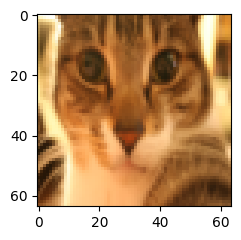

In [18]:
# Ejemplo de una imagen que ha sido correctamente clasificada
index = 3
fig = plt.figure(figsize=(2.5,2.5))
ax = fig.add_subplot(111)
ax.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)), interpolation='nearest', aspect='auto')
print(f'Siendo y = {str(test_set_y[0,index])} hemos predicho y = {modelo_regresion_logistica["Y_prediccion_test"][0,index]}')
print("Imagen:")

In [19]:
# Comparar visualmente resultados con datos reales
print(modelo_regresion_logistica["Y_prediccion_test"][0,13:18])
print(test_set_y[0,13:18])
def comparar(x, y):
    return "Coinciden" if x == y else "No coinciden"

resultado = map(comparar, modelo_regresion_logistica["Y_prediccion_test"][0,13:18], test_set_y[0,13:18])
print(list(resultado))

[1. 0. 1. 0. 1.]
[0 0 1 0 1]
['No coinciden', 'Coinciden', 'Coinciden', 'Coinciden', 'Coinciden']


La mejor opción para visualizar la precisión conseguida es la matriz de confusión, para lo cual nos valdremos de la biblioteca _sklearn_. Hay que convertir los datos en un array unidemensional para que funcione la función:

In [20]:
modelo_regresion_logistica['Y_prediccion_test'].shape

(1, 50)

In [21]:
test_set_y.shape

(1, 50)

In [22]:
np.squeeze(test_set_y.reshape(-1,1)).shape

(50,)

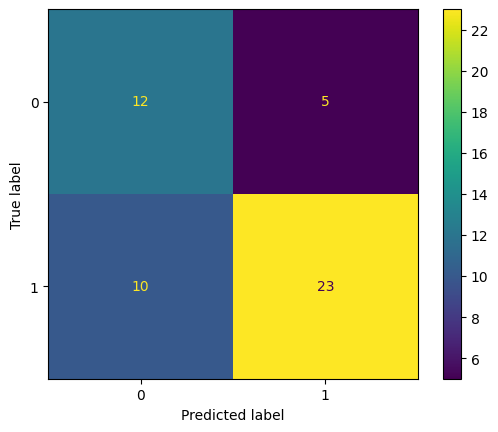

In [23]:
cm = confusion_matrix(np.squeeze(test_set_y.reshape(-1,1)), np.squeeze(modelo_regresion_logistica['Y_prediccion_test'].reshape(-1,1)))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)

cm_display.plot()
plt.show()

<a name='6'></a>
## 6 - Análisis ##

Analicemos un poco más el modelo explorando uno de sus hiperparámetros, la tasa de aprendizaje, $\alpha$. 

#### Elección de la tasa de aprendizaje ####

Para que el descenso del gradiente funcione, se debe elegir bien la tasa de aprendizaje. La tasa de aprendizaje $\alpha$ determina la rapidez con la que actualizamos los parámetros. Si la tasa de aprendizaje es demasiado grande podemos "sobrepasar" el valor óptimo. Del mismo modo, si es demasiado pequeña, necesitaremos demasiadas iteraciones para converger. Por eso es crucial utilizar una tasa de aprendizaje bien ajustada.

Comparemos la curva de aprendizaje de nuestro modelo con otras opciones de tasas de aprendizaje. En primer lugar, unas tasas no problemáticas, que funcionan mejor o peor:

Entrenamiendo del modelo con tasa de aprendizaje: 0.01

Precisión(accuracy) en train: 99.52153110047847 %
Precision(accuracy) en test: 70.0 %

-------------------------------------------------------

Entrenamiendo del modelo con tasa de aprendizaje: 0.001

Precisión(accuracy) en train: 91.86602870813397 %
Precision(accuracy) en test: 68.0 %

-------------------------------------------------------

Entrenamiendo del modelo con tasa de aprendizaje: 0.0001

Precisión(accuracy) en train: 71.29186602870814 %
Precision(accuracy) en test: 40.0 %

-------------------------------------------------------



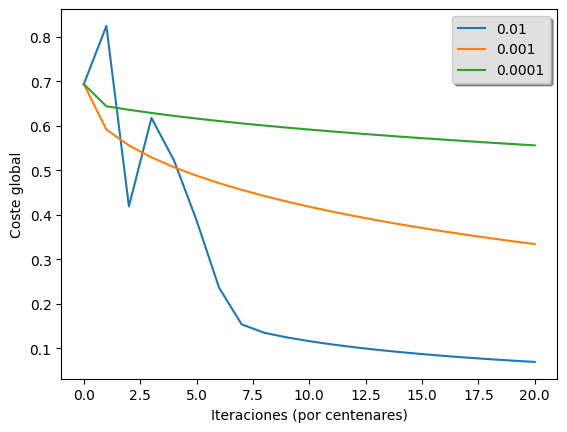

In [24]:
tasas_de_aprendizaje = [0.01, 0.001, 0.0001]
modelos = {}

for ta in tasas_de_aprendizaje:
    print("Entrenamiendo del modelo con tasa de aprendizaje: " + str(ta))
    modelos[str(ta)] = modelo(train_set_x, train_set_y, test_set_x, test_set_y, num_iteraciones=2100, tasa_aprendizaje=ta, dibujar_coste=False)
    print('\n' + "-------------------------------------------------------" + '\n')

for ta in tasas_de_aprendizaje:
    plt.plot(np.squeeze(modelos[str(ta)]["costes"]), label=str(modelos[str(ta)]["tasa_aprendizaje"]))

plt.ylabel('Coste global')
plt.xlabel('Iteraciones (por centenares)')

leyenda = plt.legend(loc='upper right', shadow=True)
marco = leyenda.get_frame()
marco.set_facecolor('0.88')
plt.show()

Aparte, y para que no estropee el gráfico, veamos una tasa problemática:

Entrenamiendo del modelo con tasa de aprendizaje: 0.1


C:\Users\rdelmazo\AppData\Local\Temp\ipykernel_21480\760352508.py:20: RuntimeWarning: divide by zero encountered in log
  coste = np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)) / -m
C:\Users\rdelmazo\AppData\Local\Temp\ipykernel_21480\760352508.py:20: RuntimeWarning: invalid value encountered in multiply
  coste = np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)) / -m



Precisión(accuracy) en train: 100.0 %
Precision(accuracy) en test: 68.0 %

-------------------------------------------------------



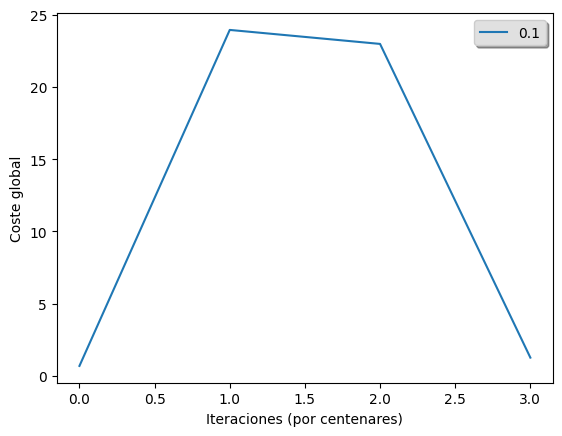

In [25]:
tasas_de_aprendizaje = [0.1]
modelos = {}

for ta in tasas_de_aprendizaje:
    print("Entrenamiendo del modelo con tasa de aprendizaje: " + str(ta))
    modelos[str(ta)] = modelo(train_set_x, train_set_y, test_set_x, test_set_y, num_iteraciones=2100, tasa_aprendizaje=ta, dibujar_coste=False)
    print('\n' + "-------------------------------------------------------" + '\n')

for ta in tasas_de_aprendizaje:
    plt.plot(np.squeeze(modelos[str(ta)]["costes"]), label=str(modelos[str(ta)]["tasa_aprendizaje"]))

plt.ylabel('Coste global')
plt.xlabel('Iteraciones (por centenares)')

leyenda = plt.legend(loc='upper right', shadow=True)
marco = leyenda.get_frame()
marco.set_facecolor('0.88')
plt.show()

**Interpretación y comentarios finales**: 

- Diferentes tasas de aprendizaje dan diferentes costes globales y, por tanto, diferentes resultados de predicción.
- Si la tasa de aprendizaje es demasiado alta (0.1 o 0.01), el coste puede oscilar arriba y abajo; incluso puede **divergir**. En estos ejemplos, el uso de 0.1 provoca una divergencia; 0.01 comienza divergiendo pero acaba dando un buen valor al coste. Con 0.1 vemos que la precisión del entrenamiento es del 100%, mientras que el conjunto test es del 68%. Esto demuestra ese intercambio cuando hay un sobreajuste, donde si sube la precisión del conjunto de entrenamiento, baja la del conjunto de prueba.
- Un **coste global más bajo no significa necesariamente un modelo mejor**. Hay que comprobar si existe la posibilidad de sobreajuste (_overfitting_). Es fácil ver que hay sobreajuste si la precisión del entrenamiento es extremandamente buena y/o dista mucho de la precisión conseguida en el conjunto de prueba.
- En aprendizaje profundo, unas recomendaciones generales son: 
    - Elegir la tasa de aprendizaje que mejor minimice la función de coste.
    - Si el modelo se ajusta bien en exceso a los datos de entrenamiento, utilizar otras técnicas para reducir el sobreajuste.
- Otras aproximaciones para mejorar los resultados:
    - Variar la tasa de aprendizaje y el número de iteraciones
    - Probar diferentes métodos de inicialización.
    - Probar otros preprocesamientos (centrar los datos, dividir cada fila por su desviación estándar, etc)

Cat Images Dataset
    
- https://www.kaggle.com/datasets/mriganksingh/cat-images-dataset
    
Otras fuentes:

- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
    
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c